In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy.fft import fft, fftfreq

In [3]:
import os
import tqdm
import numpy as np
import librosa

# Define paths and labels
base_dir = "/content/drive/MyDrive/signal_analysis/data"
class_labels = ['AS', 'MR', 'MS', 'MVP', 'N']

# Function to process dataset and return logmel features
def process_dataset_with_logmel(base_dir, class_labels, sampling_rate=2000, n_mels=64, fixed_length=300):
    X_logmel = []
    y_labels = []

    for label in class_labels:
        folder_path = os.path.join(base_dir, label)

        for file_name in tqdm.tqdm(os.listdir(folder_path)):
            if file_name.endswith('.wav'):
                file_path = os.path.join(folder_path, file_name)

                # Load and resample the audio
                signal, sr = librosa.load(file_path, sr=None)
                signal = librosa.resample(signal, orig_sr=sr, target_sr=sampling_rate)
                signal = signal / np.max(np.abs(signal))  # Normalize to [-1, 1]

                # Compute log-Mel spectrogram
                mel_spec = librosa.feature.melspectrogram(y=signal, sr=sampling_rate, n_mels=n_mels)
                logmel_spec = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to log scale

                # Take mean across time or flatten
                feature_vector = np.mean(logmel_spec, axis=1)  # shape: (n_mels,)

                # Pad or trim to fixed length
                if len(feature_vector) < fixed_length:
                    feature_vector = np.pad(feature_vector, (0, fixed_length - len(feature_vector)), mode='constant')
                else:
                    feature_vector = feature_vector[:fixed_length]

                X_logmel.append(feature_vector)
                y_labels.append(label)

    return np.array(X_logmel), np.array(y_labels)

# Process the dataset with logmel
X_logmel, y_logmel = process_dataset_with_logmel(base_dir, class_labels)


100%|██████████| 200/200 [00:03<00:00, 56.57it/s] 


In [4]:
def process_dataset_with_logmel(base_dir, class_labels, sampling_rate=2000, feature_length=300, n_mels=64):
    X_logmel = []
    y_labels = []

    def pad_or_truncate(feature, target_length):
        if len(feature) > target_length:
            return feature[:target_length]
        else:
            return np.pad(feature, (0, target_length - len(feature)), mode='constant')

    for label in class_labels:
        folder_path = os.path.join(base_dir, label)

        for file_name in tqdm.tqdm(os.listdir(folder_path)):
            if file_name.endswith('.wav'):
                file_path = os.path.join(folder_path, file_name)

                # Load and preprocess audio
                signal, sr = librosa.load(file_path, sr=None)
                signal = librosa.resample(signal, orig_sr=sr, target_sr=sampling_rate)
                signal = signal / np.max(np.abs(signal))  # Normalize

                # Compute Mel spectrogram and convert to log scale
                mel_spec = librosa.feature.melspectrogram(y=signal, sr=sampling_rate, n_mels=n_mels)
                logmel_spec = librosa.power_to_db(mel_spec, ref=np.max)

                # Take mean over time to get a 1D feature
                logmel_feature = np.mean(logmel_spec, axis=1)  # shape: (n_mels,)

                # Pad or truncate
                logmel_feature = pad_or_truncate(logmel_feature, feature_length)

                X_logmel.append(logmel_feature)
                y_labels.append(label)

    return np.array(X_logmel), np.array(y_labels)


In [5]:
X_logmel, y_logmel = process_dataset_with_logmel(base_dir, class_labels)


100%|██████████| 200/200 [00:02<00:00, 92.52it/s] 


In [6]:
type(y_logmel)

numpy.ndarray

In [7]:
np.unique(y_logmel)

array(['AS', 'MR', 'MS', 'MVP', 'N'], dtype='<U3')

In [8]:
# Get unique elements and create a mapping to integers
unique_elements = np.unique(y_logmel)
mapping = {elem: idx for idx, elem in enumerate(unique_elements)}

# Map the original array to integers
y_logmel_enc = np.vectorize(mapping.get)(y_logmel)


In [9]:
import pandas as pd

# Assuming y_logmel_enc is already the integer-encoded label array
y_onehot_logmel = pd.get_dummies(y_logmel_enc).values
print(y_onehot_logmel.shape)

(1000, 5)


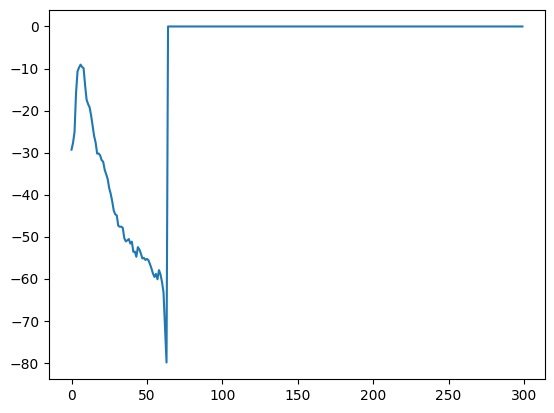

In [10]:
plt.plot(X_logmel[0])

In [11]:
import os
import librosa
import numpy as np
import tqdm
from sklearn.preprocessing import LabelEncoder

# Parameters
base_dir = "/content/drive/MyDrive/signal_analysis/data"
class_labels = ['AS', 'MR', 'MS', 'MVP', 'N']
sampling_rate = 2000
n_mels = 64

X_logmel_2d = []
y_logmel_2d = []
mel_specs = []
max_time_frames = 0

# Step 1: Compute mel-spectrograms (NOT in dB) and find max time frames
for label in class_labels:
    folder_path = os.path.join(base_dir, label)

    for file_name in tqdm.tqdm(os.listdir(folder_path), desc=f"Processing {label}"):
        if file_name.endswith(".wav"):
            file_path = os.path.join(folder_path, file_name)

            # Load and normalize
            signal, sr = librosa.load(file_path, sr=None)
            signal = librosa.resample(signal, orig_sr=sr, target_sr=sampling_rate)
            signal = signal / np.max(np.abs(signal))

            # Compute mel-spectrogram (linear scale)
            mel_spec = librosa.feature.melspectrogram(y=signal, sr=sampling_rate, n_mels=n_mels)

            # Track time dimension
            max_time_frames = max(max_time_frames, mel_spec.shape[1])

            mel_specs.append(mel_spec)
            y_logmel_2d.append(label)

# Step 2: Pad all mel-spectrograms (still in linear scale)
for mel_spec in mel_specs:
    pad_width = max_time_frames - mel_spec.shape[1]
    mel_padded = np.pad(mel_spec, ((0, 0), (0, pad_width)), mode='constant')  # Pad time axis with 0s

    # Now convert to log scale
    logmel_spec = librosa.power_to_db(mel_padded, ref=np.max)

    X_logmel_2d.append(logmel_spec)

# Step 3: Convert to NumPy arrays
X_logmel_2d = np.array(X_logmel_2d)  # shape: (samples, n_mels, time)
y_logmel_2d = np.array(y_logmel_2d)

# Step 4: Encode labels
label_encoder = LabelEncoder()
y_logmel_enc = label_encoder.fit_transform(y_logmel_2d)


Processing N: 100%|██████████| 200/200 [00:01<00:00, 107.37it/s]


In [12]:
print("X_logmel shape:", X_logmel_2d.shape)  # e.g., (100, 64, 300)
print("y_logmel shape:", y_logmel_2d.shape)  # e.g., (100,)

X_logmel shape: (1000, 64, 16)
y_logmel shape: (1000,)


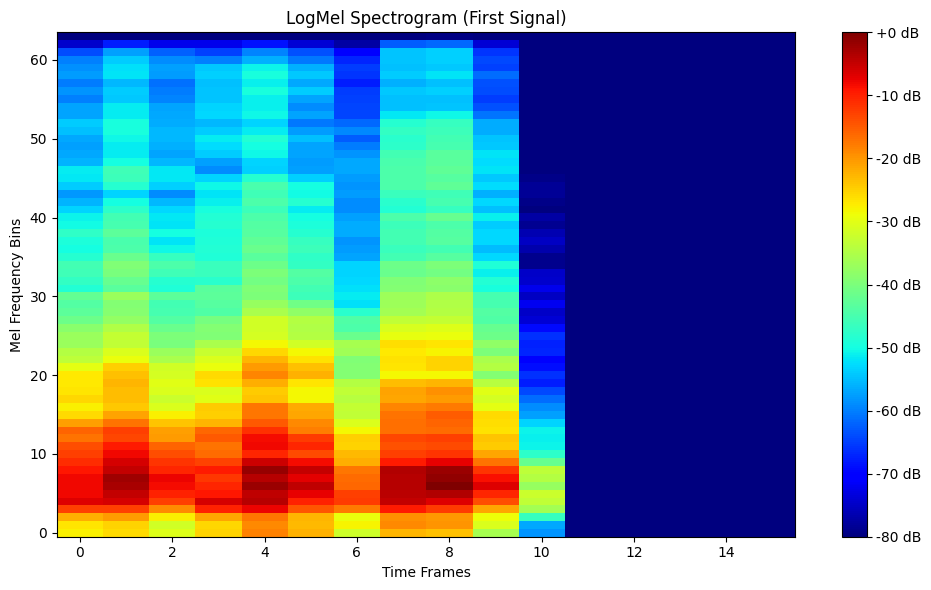

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.imshow(X_logmel_2d[0],
           aspect='auto',
           origin='lower',
           cmap='jet')
plt.colorbar(format='%+2.0f dB')
plt.xlabel("Time Frames")
plt.ylabel("Mel Frequency Bins")
plt.title("LogMel Spectrogram (First Signal)")
plt.tight_layout()
plt.show()


# **CNN**


- Defining a CNN
- Compiling it
- Training on your X_train, y_train
- Evaluating on X_test, y_test

In [14]:
from sklearn.model_selection import train_test_split
import numpy as np

# y_logmel_enc is already an integer array like [0, 1, 4, 2, ...]

# Split using integer labels for stratification
X_train, X_test, y_train_enc, y_test_enc = train_test_split(
    X_logmel_2d,
    y_logmel_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_logmel_enc  # Use encoded integer labels for class balance
)


In [15]:
# CNN expects (samples, height, width, channels)
X_train = X_train[..., np.newaxis]  # (samples, n_mels, time, 1)
X_test = X_test[..., np.newaxis]


In [16]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train_enc)
y_test = to_categorical(y_test_enc)


In [17]:
print(f'X_train_cnn shape: {X_train.shape}')  # e.g. (samples, 64, time, 1)
print(f'X_test_cnn shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')  # e.g. (samples, 5)
print(f'y_test shape: {y_test.shape}')


X_train_cnn shape: (800, 64, 16, 1)
X_test_cnn shape: (200, 64, 16, 1)
y_train shape: (800, 5)
y_test shape: (200, 5)


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import numpy as np

# CNN expects (samples, height, width, channels)
X_train_cnn = X_train[..., np.newaxis]  # (samples, n_mels, time, 1)
X_test_cnn = X_test[..., np.newaxis]


# Use the correct input shape for LogMel spectrograms
input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2], 1)  # (n_mels, time, 1)

cnn_model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')  # number of classes
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 8, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 8, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 8, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 4, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 4, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 4, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,485 (1.36 MB)

 Trainable params: 356,037 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [21]:
# --- Compile, Train, and Evaluate the CNN model on Enhanced LogMel Spectrograms ---
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = cnn_model.fit(
    X_train_cnn, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_test_cnn, y_test),
    verbose=1
)

test_loss, test_acc = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"Enhanced LogMel CNN Accuracy: {test_acc * 100:.2f}%")


Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.4110 - loss: 2.1644 - val_accuracy: 0.2000 - val_loss: 8.0523
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.7348 - loss: 0.7038 - val_accuracy: 0.2000 - val_loss: 3.8683
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.7919 - loss: 0.5231 - val_accuracy: 0.4050 - val_loss: 1.5576
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.8591 - loss: 0.4268 - val_accuracy: 0.5000 - val_loss: 1.3530
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.9190 - loss: 0.2466 - val_accuracy: 0.5400 - val_loss: 1.1583
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.9128 - loss: 0.2385 - val_accuracy: 0.7200 - val_loss: 0.7186
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9454 - loss: 0.1943 - val_accuracy: 0.7350 - val_loss: 0.6227
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9519 - loss: 0.1649 - val_accuracy: 0.865

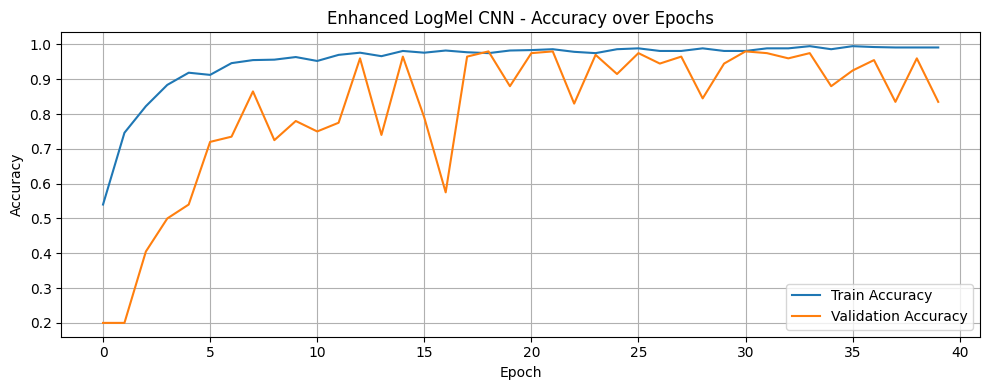

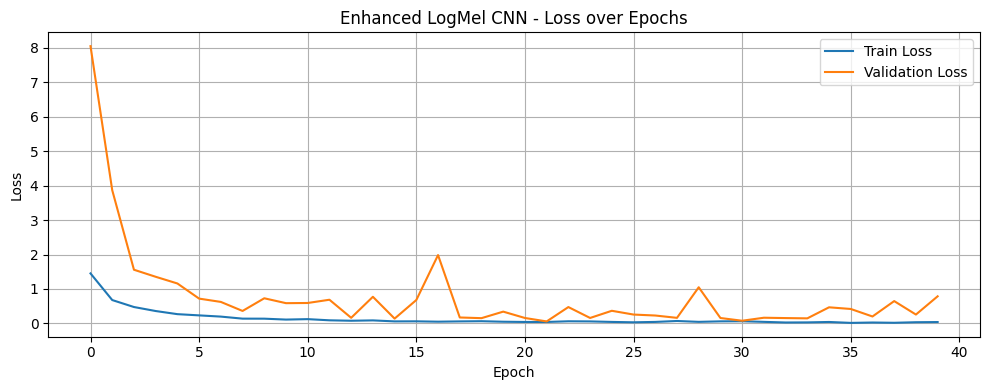

In [22]:
import matplotlib.pyplot as plt

# --- Plot Accuracy ---
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Enhanced LogMel CNN - Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot Loss ---
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Enhanced LogMel CNN - Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
test_loss, test_accuracy = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 0.8350
Test Loss: 0.7854


# **Plot Epochs vs. Loss and Accuracy**

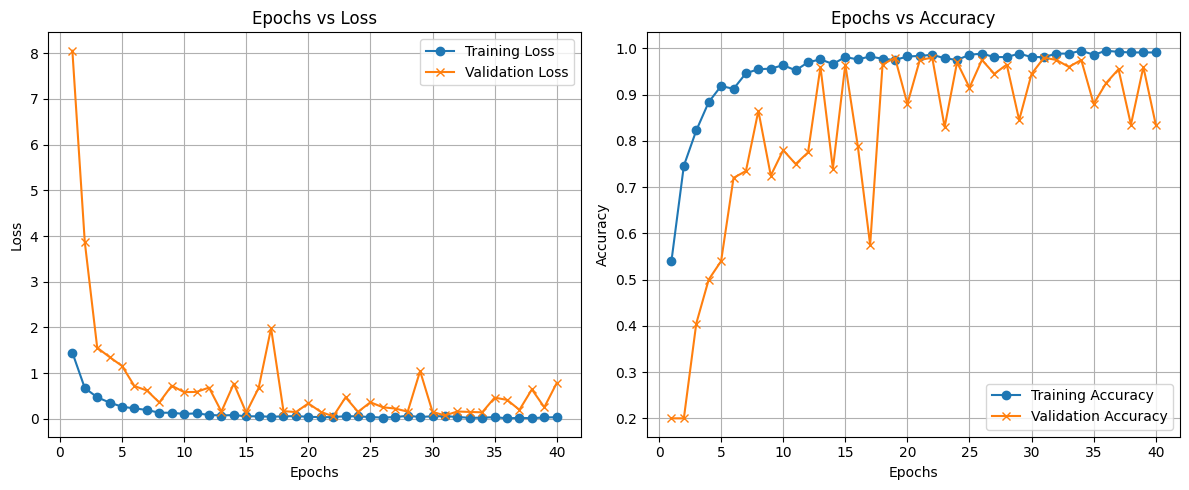

In [24]:
import matplotlib.pyplot as plt

# Extract training history
epochs = range(1, len(history.history['loss']) + 1)
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create subplots
plt.figure(figsize=(12, 5))

# --- Plot Loss ---
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='x')
plt.title('Epochs vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- Plot Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='x')
plt.title('Epochs vs Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Final layout
plt.tight_layout()
plt.show()


# **GRU -> Flatten -> Dense Layer**

In [25]:
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import GRU, Dense, Dropout, Flatten, Reshape, Permute
import matplotlib.pyplot as plt


In [26]:
# Split the data
X_train_raw, X_test_raw, y_train_enc, y_test_enc = train_test_split(
    X_logmel_2d,
    y_logmel_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_logmel_enc
)

# Reshape for CNN input: (samples, n_mels, time, 1)
X_train = X_train_raw[..., np.newaxis]
X_test = X_test_raw[..., np.newaxis]

# One-hot encode labels
y_train = to_categorical(y_train_enc)
y_test = to_categorical(y_test_enc)


In [27]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)  # (n_mels, time, 1)

cnn_gru_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Reshape CNN output to (batch, time, features) for GRU
    Permute((2, 1, 3)),             # (batch, time, freq, channels)
    Reshape((-1, 64)),              # Flatten freq x channels

    GRU(64, return_sequences=False),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')  # output layer
])


In [28]:
cnn_gru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 8, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 8, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 8, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 4, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 4, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 4, 16, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,125 (207.52 KB)

 Trainable params: 52,933 (206.77 KB)

 Non-trainable params: 192 (768.00 B)

In [29]:
cnn_gru_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = cnn_gru_model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)
test_loss, test_acc = cnn_gru_model.evaluate(X_test, y_test, verbose=0)
print(f"Enhanced LogMel CNN + GRU Accuracy: {test_acc * 100:.2f}%")

Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 0.2247 - loss: 1.6776 - val_accuracy: 0.2000 - val_loss: 1.6569
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.2532 - loss: 1.6202 - val_accuracy: 0.2800 - val_loss: 1.5685
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - accuracy: 0.2910 - loss: 1.5275 - val_accuracy: 0.3250 - val_loss: 1.5325
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.3522 - loss: 1.4619 - val_accuracy: 0.2900 - val_loss: 1.4984
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.3690 - loss: 1.3817 - val_accuracy: 0.3400 - val_loss: 1.4343
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.4240 - loss: 1.3323 - val_accuracy: 0.3950 - val_loss: 1.3664
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.5013 - loss: 1.2345 - val_accuracy: 0.2150 - val_loss: 1.6869
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.5740 - loss: 1.0729 - val_accuracy: 0.

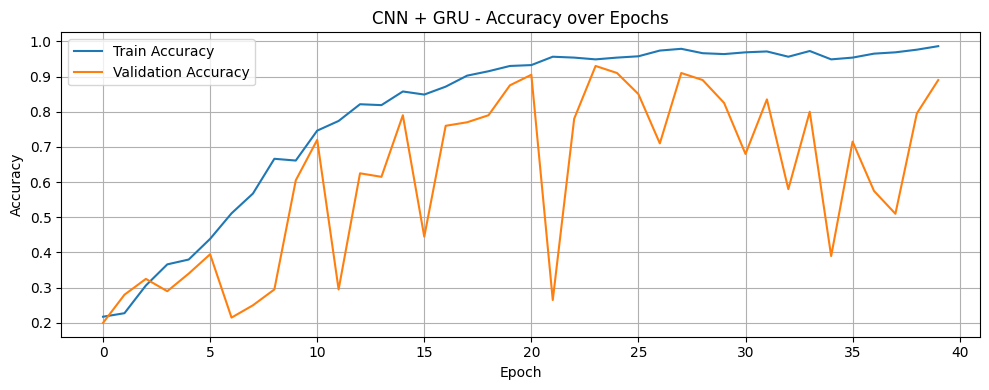

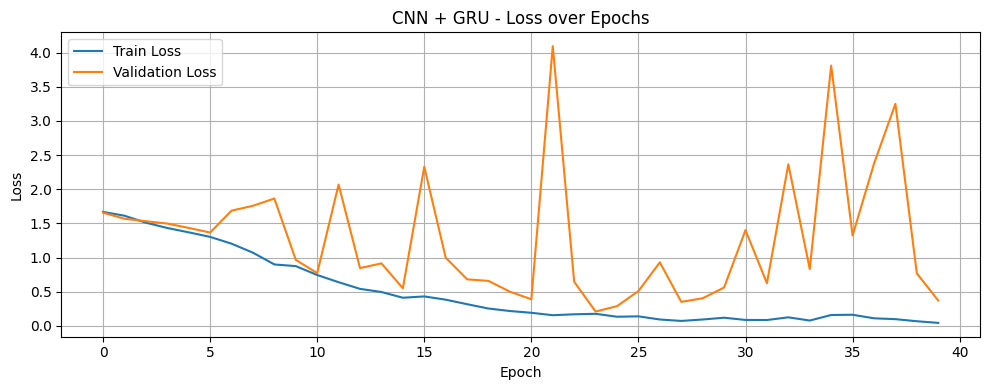

In [30]:
# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN + GRU - Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN + GRU - Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
test_loss, test_accuracy = cnn_gru_model.evaluate(X_test, y_test, verbose=0)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.8900
Test Loss: 0.3724


# **Flatten -> GRU -> Dense layer**

In [32]:
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Flatten, Reshape, GRU, Dense, Dropout
import matplotlib.pyplot as plt

In [33]:
# Split the data
X_train_raw, X_test_raw, y_train_enc, y_test_enc = train_test_split(
    X_logmel_2d, y_logmel_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_logmel_enc
)

# Reshape to (samples, n_mels, time, 1)
X_train = X_train_raw[..., np.newaxis]
X_test = X_test_raw[..., np.newaxis]

# One-hot encode
y_train = to_categorical(y_train_enc)
y_test = to_categorical(y_test_enc)


In [34]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)  # (n_mels, time, 1)

model = Sequential([
    # CNN layers
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Flatten and reshape for GRU
    Flatten(),                                  # (batch, features)
    Reshape((-1, 64)),                          # (batch, sequence_len, feature_size)

    GRU(64, return_sequences=False),            # Single GRU layer

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

In [35]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 64, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 8, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 8, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 8, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 4, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 4, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,125 (207.52 KB)

 Trainable params: 52,933 (206.77 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Flatten → GRU → Dense Accuracy: {test_acc * 100:.2f}%")

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.2046 - loss: 1.6751 - val_accuracy: 0.1900 - val_loss: 1.7233
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - accuracy: 0.3028 - loss: 1.5367 - val_accuracy: 0.2050 - val_loss: 1.7341
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.3740 - loss: 1.4188 - val_accuracy: 0.2000 - val_loss: 1.8526
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.4482 - loss: 1.2718 - val_accuracy: 0.2000 - val_loss: 1.9169
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.5887 - loss: 1.0759 - val_accuracy: 0.2000 - val_loss: 1.9378
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - accuracy: 0.6667 - loss: 0.9317 - val_accuracy: 0.2000 - val_loss: 2.6254
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.6996 - loss: 0.7931 - val_accuracy: 0.2250 - val_loss: 1.8552
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.7598 - loss: 0.6395 - val_accuracy: 0.

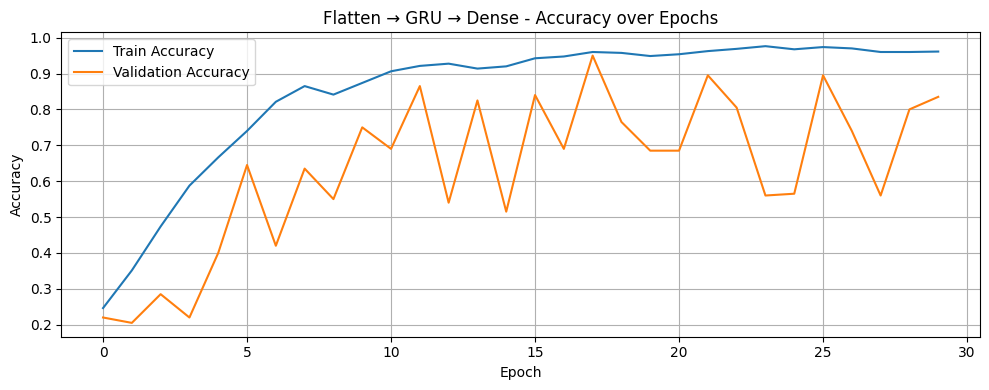

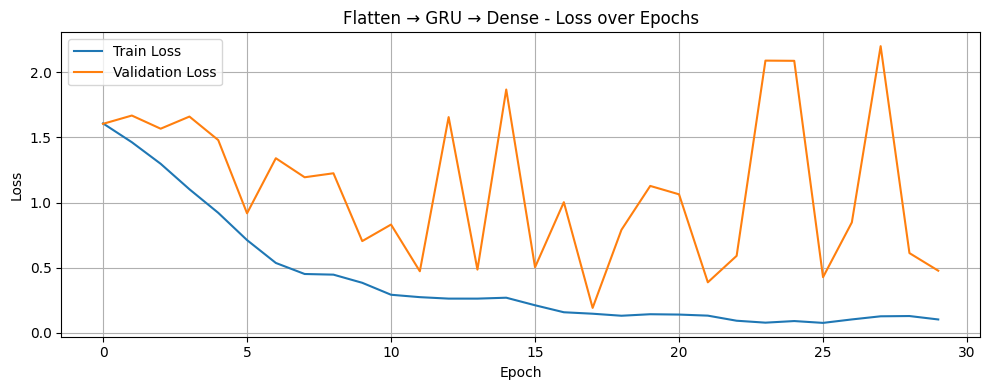

In [28]:
# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Flatten → GRU → Dense - Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Flatten → GRU → Dense - Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Print test performance
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.8350
Test Loss: 0.4771


# **CNN + Attention Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# --- Custom Attention Layer ---
class AttentionLayer(layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        dim = input_shape[-1]
        self.query = self.add_weight(name="query", shape=(dim, dim), initializer="glorot_uniform", trainable=True)
        self.key   = self.add_weight(name="key", shape=(dim, dim), initializer="glorot_uniform", trainable=True)
        self.value = self.add_weight(name="value", shape=(dim, dim), initializer="glorot_uniform", trainable=True)

    def call(self, inputs):
        Q = tf.matmul(inputs, self.query)
        K = tf.matmul(inputs, self.key)
        V = tf.matmul(inputs, self.value)

        attention_scores = tf.matmul(Q, K, transpose_b=True)
        dk = tf.cast(tf.shape(K)[-1], tf.float32)
        attention_weights = tf.nn.softmax(attention_scores / tf.math.sqrt(dk), axis=-1)

        return tf.matmul(attention_weights, V)

# --- Define CNN + Attention Model ---
input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2], 1)  # e.g., (64, 300, 1)

inputs = layers.Input(shape=input_shape)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Reshape from 4D (batch, height, width, channels) to 3D (batch, time, features)
x = layers.Reshape((x.shape[1]*x.shape[2], x.shape[3]))(x)  # Flatten H and W into sequence

x = AttentionLayer()(x)

x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(y_train.shape[1], activation='softmax')(x)  # 5 classes → softmax

cnn_attention_model = models.Model(inputs=inputs, outputs=outputs)


In [ ]:
cnn_attention_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 64, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 32, 8, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 8, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 4, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 64, 64)         │        12,288 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 293,637 (1.12 MB)

 Trainable params: 293,637 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

In [1]:
cnn_attention_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = cnn_attention_model.fit(
    X_train_cnn, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test_cnn, y_test),
    verbose=1
)

# Evaluation
loss, acc = cnn_attention_model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"Attention CNN Accuracy: {acc * 100:.2f}%")
print(f"Attention CNN Loss: {test_loss:.4f}")


NameError: name 'cnn_attention_model' is not defined

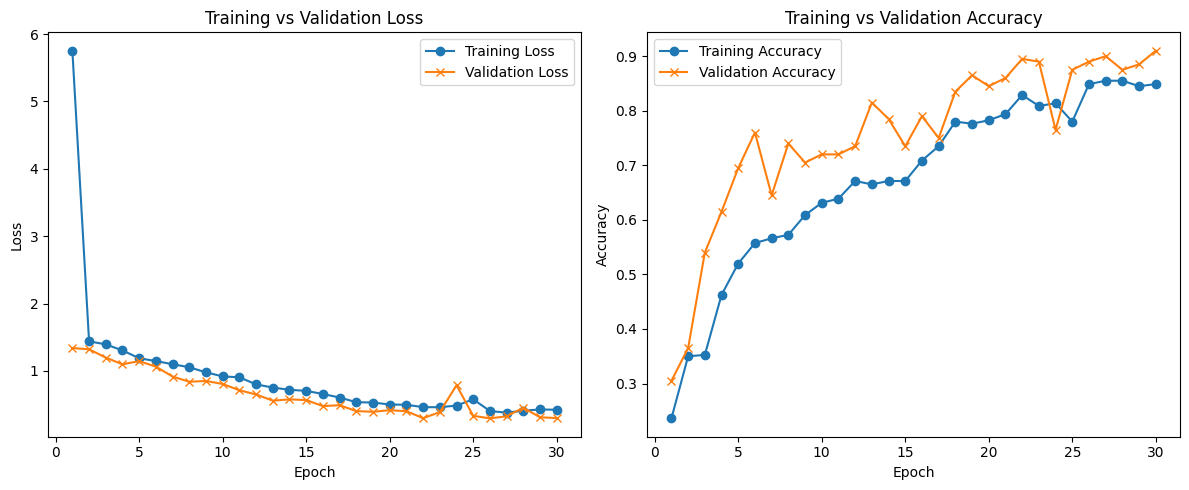

In [ ]:
import matplotlib.pyplot as plt

# Extract training history
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])
accuracy = history.history.get('accuracy', [])
val_accuracy = history.history.get('val_accuracy', [])
epochs = range(1, len(loss) + 1)

# Check if training ran for more than 1 epoch
if len(loss) > 1:
    plt.figure(figsize=(12, 5))

    # --- Plot Loss ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='x')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # plt.grid(True)

    # --- Plot Accuracy ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='x')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    # plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
plt.savefig("enhanced_logmel_training_plot.png", dpi=300)


<Figure size 640x480 with 0 Axes>